In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

In [109]:
pd.set_option('display.max_rows', 100)

## Load Data

In [2]:
aisles = pd.read_csv('data/aisles.csv', dtype = {
    'aisle_id': np.uint8,
    'aisle': np.str},
    usecols=['aisle_id', 'aisle'])

In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
departments = pd.read_csv('data/departments.csv', dtype = {
    'department_id': np.uint8,
    'department': np.str},
    usecols=['department_id', 'department'])

In [5]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [76]:
order_products_prior = pd.read_csv('data/order_products__prior.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint16,
    'add_to_cart_order': np.uint8,
    'reordered': np.uint8},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [77]:
order_products_prior[order_products_prior.order_id == 2539329]

,order_id,product_id,add_to_cart_order,reordered
24076664,2539329,196,1,0
24076665,2539329,14084,2,0
24076666,2539329,12427,3,0
24076667,2539329,26088,4,0
24076668,2539329,26405,5,0


In [48]:
order_product_train = pd.read_csv('data/order_products__train.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint16,
    'add_to_cart_order': np.uint8,
    'reordered': np.uint8},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [74]:
order_product_train[order_product_train.order_id == 1187899]

,order_id,product_id,add_to_cart_order,reordered
484420,1187899,196,1,1
484421,1187899,25133,2,1
484422,1187899,38928,3,1
484423,1187899,26405,4,1
484424,1187899,39657,5,1
484425,1187899,10258,6,1
484426,1187899,13032,7,1
484427,1187899,26088,8,1
484428,1187899,27845,9,0
484429,1187899,49235,10,1


In [51]:
order_product_train.reordered.value_counts()

1    828824
0    555793
Name: reordered, dtype: int64

In [69]:
orders = pd.read_csv('data/orders.csv', dtype = {
    'order_id': np.uint32,
    'user_id' :np.uint32,
    'eval_set': 'category',
    'order_number': np.int16,
    'order_dow': np.int8,
    'order_hour_of_day': np.int8,
    'days_since_prior_order': np.float32},
                     usecols=['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'])

In [83]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [85]:
products = pd.read_csv('data/products.csv', dtype = {'product_id': np.uint16,
        'product_name': np.str,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'product_name', 'aisle_id', 'department_id'])

In [92]:
products.aisle_id.max()

134

In [14]:
products.shape

(49688, 4)

## Generating Features

In [18]:
orders['days_since_first_order'] = orders.groupby('user_id')['days_since_prior_order'].cumsum()

In [19]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,2539329,1,prior,1,2,8,NaN,NaN
1,2398795,1,prior,2,3,7,15.0,15.0
2,473747,1,prior,3,3,12,21.0,36.0
3,2254736,1,prior,4,4,7,29.0,65.0
4,431534,1,prior,5,4,15,28.0,93.0


In [20]:
orders.shape

(3421083, 8)

In [21]:
#order_products_prior_new = pd.merge(order_products_prior, orders, on = 'order_id', how = 'left')
order_products_train_new = pd.merge(order_product_train, orders, on = 'order_id', how = 'left')

In [19]:
#order_products_prior_new.sort_values(['user_id', 'order_number']).head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
24076664,2539329,196,1,0,1,prior,1,2,8,NaN,NaN
24076665,2539329,14084,2,0,1,prior,1,2,8,NaN,NaN
24076666,2539329,12427,3,0,1,prior,1,2,8,NaN,NaN
24076667,2539329,26088,4,0,1,prior,1,2,8,NaN,NaN
24076668,2539329,26405,5,0,1,prior,1,2,8,NaN,NaN
22742744,2398795,196,1,1,1,prior,2,3,7,15.0,15.0
22742745,2398795,10258,2,0,1,prior,2,3,7,15.0,15.0
22742746,2398795,12427,3,1,1,prior,2,3,7,15.0,15.0
22742747,2398795,13176,4,0,1,prior,2,3,7,15.0,15.0
22742748,2398795,26088,5,1,1,prior,2,3,7,15.0,15.0


In [20]:
#order_products_prior_new['days_since_first_order'].fillna(0, inplace=True)

In [21]:
#order_products_prior_new.sort_values(['user_id', 'product_id','order_number'], inplace = True)

In [ ]:
#%time
#order_products_prior_new['days_since_prior_purchase_product'] = order_products_prior_new.groupby(['user_id', 'product_id'])['days_since_first_order'].transform(lambda x: x.diff())

In [22]:
import pickle
#pickle.dump(order_products_prior_new, open('data/user_order_product_new.p', 'wb'))

In [23]:
order_products_prior_new = pickle.load(open('data/user_order_product_new.p', 'rb'))
order_products_prior_new.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,days_since_prior_purchase_product
24076664,2539329,196,1,0,1,prior,1,2,8,NaN,0.0,NaN
22742744,2398795,196,1,1,1,prior,2,3,7,15.0,15.0,15.0
4488095,473747,196,1,1,1,prior,3,3,12,21.0,36.0,21.0
21376074,2254736,196,1,1,1,prior,4,4,7,29.0,65.0,29.0
4089398,431534,196,1,1,1,prior,5,4,15,28.0,93.0,28.0


In [24]:
user_product_info = pd.DataFrame(order_products_prior_new.groupby(['user_id', 'product_id'])['order_number'].count())

In [25]:
user_product_info.reset_index(inplace = True)

In [26]:
user_product_info = pd.merge(user_product_info, pd.DataFrame(order_products_prior_new.groupby(['user_id', 'product_id'])['days_since_prior_purchase_product'].mean()).reset_index(), on = ['user_id', 'product_id'], how = 'left')

In [27]:
user_product_info.rename(columns={'order_number': 'user_product_count', 'days_since_prior_purchase_product': 'user_product_average_interval'}, inplace = True)

In [28]:
user_product_info.head()

,user_id,product_id,user_product_count,user_product_average_interval
0,1,196,10,19.555555
1,1,10258,9,20.125000
2,1,10326,1,NaN
3,1,12427,10,19.555555
4,1,13032,3,80.500000


In [29]:
user_info = pd.DataFrame()
user_info['user_count_of_order'] = orders.groupby('user_id').size().astype(np.int16)
user_info['user_average_order_interval'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.int16)
user_info.reset_index(inplace = True)

In [30]:
user_info.head()

,user_id,user_count_of_order,user_average_order_interval
0,1,11,19
1,2,15,16
2,3,13,12
3,4,6,17
4,5,5,11


In [31]:
product_info = pd.DataFrame()
product_info['product_total_purchase_count'] = order_products_prior_new.groupby('product_id').size().astype(np.int32)
product_info['product_user_count'] = order_products_prior_new.groupby('product_id')['user_id'].nunique().astype(np.int32)

In [32]:
product_info.reset_index(inplace = True)

In [33]:
product_info.head()

,product_id,product_total_purchase_count,product_user_count
0,1,1852,716
1,2,90,78
2,3,277,74
3,4,329,182
4,5,15,6


In [34]:
tempdf = pd.DataFrame(user_product_info[user_product_info['user_product_count'] > 1].groupby('product_id')['user_id'].nunique().astype(np.int32)).reset_index()

In [35]:
tempdf.rename(columns = {'user_id': 'product_reorder_user_count'}, inplace = True)

In [36]:
product_info = pd.merge(product_info, tempdf, on='product_id', how = 'left')

In [37]:
product_info.fillna(0, inplace = True)

In [38]:
product_info.head()

,product_id,product_total_purchase_count,product_user_count,product_reorder_user_count
0,1,1852,716,276.0
1,2,90,78,8.0
2,3,277,74,36.0
3,4,329,182,64.0
4,5,15,6,4.0


In [40]:
product_info['product_reorder_ratio'] = product_info['product_reorder_user_count']/product_info['product_user_count']

In [41]:
product_info.head()

,product_id,product_total_purchase_count,product_user_count,product_reorder_user_count,product_reorder_ratio
0,1,1852,716,276.0,0.385475
1,2,90,78,8.0,0.102564
2,3,277,74,36.0,0.486486
3,4,329,182,64.0,0.351648
4,5,15,6,4.0,0.666667


In [42]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,2539329,1,prior,1,2,8,NaN,NaN
1,2398795,1,prior,2,3,7,15.0,15.0
2,473747,1,prior,3,3,12,21.0,36.0
3,2254736,1,prior,4,4,7,29.0,65.0
4,431534,1,prior,5,4,15,28.0,93.0


In [43]:
order_products_train_new.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,1,49302,1,1,112108,train,4,4,10,9.0,31.0
1,1,11109,2,1,112108,train,4,4,10,9.0,31.0
2,1,10246,3,0,112108,train,4,4,10,9.0,31.0
3,1,49683,4,0,112108,train,4,4,10,9.0,31.0
4,1,43633,5,1,112108,train,4,4,10,9.0,31.0


In [44]:
masterdf = order_products_train_new

In [45]:
masterdf = pd.merge(masterdf, user_info, on = 'user_id', how = 'left')

In [46]:
masterdf = pd.merge(masterdf, user_product_info, on = ['user_id', 'product_id'], how = 'left')

In [47]:
masterdf = pd.merge(masterdf, product_info, on = 'product_id', how = 'left')

In [49]:
masterdf.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,user_count_of_order,user_average_order_interval,user_product_count,user_product_average_interval,product_total_purchase_count,product_user_count,product_reorder_user_count,product_reorder_ratio
0,1,49302,1,1,112108,train,4,4,10,9.0,31.0,4,10,2.0,7.0,163.0,62.0,27.0,0.435484
1,1,11109,2,1,112108,train,4,4,10,9.0,31.0,4,10,2.0,7.0,4472.0,1280.0,704.0,0.550000
2,1,10246,3,0,112108,train,4,4,10,9.0,31.0,4,10,NaN,NaN,23826.0,11328.0,4771.0,0.421169
3,1,49683,4,0,112108,train,4,4,10,9.0,31.0,4,10,NaN,NaN,97315.0,30002.0,17002.0,0.566696
4,1,43633,5,1,112108,train,4,4,10,9.0,31.0,4,10,2.0,22.0,653.0,341.0,114.0,0.334311


In [51]:
masterdf.drop(['order_number', 'eval_set'], axis = 1, inplace=True)

In [67]:
masterdf.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,user_count_of_order,user_average_order_interval,user_product_count,user_product_average_interval,product_total_purchase_count,product_user_count,product_reorder_user_count,product_reorder_ratio,add_to_cart_order_categories
0,1,49302,1,1,112108,4,10,9.0,31.0,4,10,2.0,7.000000,163.0,62.0,27.0,0.435484,1-2
1,1,11109,2,1,112108,4,10,9.0,31.0,4,10,2.0,7.000000,4472.0,1280.0,704.0,0.550000,1-2
2,1,10246,3,0,112108,4,10,9.0,31.0,4,10,NaN,NaN,23826.0,11328.0,4771.0,0.421169,3-5
3,1,49683,4,0,112108,4,10,9.0,31.0,4,10,NaN,NaN,97315.0,30002.0,17002.0,0.566696,3-5
4,1,43633,5,1,112108,4,10,9.0,31.0,4,10,2.0,22.000000,653.0,341.0,114.0,0.334311,3-5
5,1,13176,6,0,112108,4,10,9.0,31.0,4,10,NaN,NaN,379450.0,63537.0,45231.0,0.711884,6-10
6,1,47209,7,0,112108,4,10,9.0,31.0,4,10,NaN,NaN,213584.0,43453.0,29031.0,0.668101,6-10
7,1,22035,8,1,112108,4,10,9.0,31.0,4,10,2.0,7.000000,59676.0,14037.0,8681.0,0.618437,6-10
8,36,39612,1,0,79431,6,18,30.0,345.0,23,15,NaN,NaN,728.0,478.0,109.0,0.228033,1-2
9,36,19660,2,1,79431,6,18,30.0,345.0,23,15,15.0,19.857143,56087.0,10529.0,6561.0,0.623136,1-2


In [53]:
#pickle.dump(masterdf, open('data/masterdf.p', 'wb'))

In [64]:
add_to_cart_bins = [0, 2, 5, 10, 1000]
add_to_cart_group_names = ['1-2', '3-5', '6-10', '>10']
masterdf['add_to_cart_order_categories'] = pd.cut(masterdf['add_to_cart_order'], add_to_cart_bins, labels=add_to_cart_group_names)

In [71]:
dow_bins = [-1, 1, 6]
dow_group_names = ['weekend', 'weekday']
masterdf['order_day'] = pd.cut(masterdf['order_dow'], dow_bins, labels=dow_group_names)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,user_count_of_order,user_average_order_interval,user_product_count,user_product_average_interval,product_total_purchase_count,product_user_count,product_reorder_user_count,product_reorder_ratio,add_to_cart_order_categories,order_day
0,1,49302,1,1,112108,4,10,9.0,31.0,4,10,2.0,7.0,163.0,62.0,27.0,0.435484,1-2,weekday
1,1,11109,2,1,112108,4,10,9.0,31.0,4,10,2.0,7.0,4472.0,1280.0,704.0,0.550000,1-2,weekday
2,1,10246,3,0,112108,4,10,9.0,31.0,4,10,NaN,NaN,23826.0,11328.0,4771.0,0.421169,3-5,weekday
3,1,49683,4,0,112108,4,10,9.0,31.0,4,10,NaN,NaN,97315.0,30002.0,17002.0,0.566696,3-5,weekday
4,1,43633,5,1,112108,4,10,9.0,31.0,4,10,2.0,22.0,653.0,341.0,114.0,0.334311,3-5,weekday


In [72]:
hour_bins = [-1, 6, 12, 18, 24]
hour_group_names = ['early_morning', 'morning', 'afternoon', 'night']
masterdf['time_of_day'] = pd.cut(masterdf['order_hour_of_day'], hour_bins, labels=hour_group_names)

In [82]:
masterdf['order_time'] = masterdf['order_day'].astype(str) + ' ' + masterdf['time_of_day'].astype(str)

In [88]:
user_history_bins = [-1, 30, 60, 90, 180, 360, 10000]
user_history_group_names = ['1mon', ' 2mon', '3mon', '6mon', '1year', '>1year']
masterdf['user_history_category'] = pd.cut(masterdf['days_since_first_order'], user_history_bins, labels=user_history_group_names)

In [95]:
user_order_count_bins = [-1, 10, 30, 60, 100,]
user_order_count_group_names = ['4-10', ' 11-30', '31-60', '61-100']
masterdf['user_count_of_order_category'] = pd.cut(masterdf['user_count_of_order'], user_order_count_bins, labels=user_order_count_group_names)

In [99]:
user_order_interval_bins = [-1, 5, 10, 20, 30,]
user_order_interval_group_names = ['1-5', ' 6-10', '11-20', '21-30']
masterdf['user_order_interval_category'] = pd.cut(masterdf['user_average_order_interval'], user_order_interval_bins, labels=user_order_interval_group_names)

In [97]:
masterdf.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'days_since_first_order', 'user_count_of_order',
       'user_average_order_interval', 'user_product_count',
       'user_product_average_interval', 'product_total_purchase_count',
       'product_user_count', 'product_reorder_user_count',
       'product_reorder_ratio', 'add_to_cart_order_categories', 'order_day',
       'time_of_day', 'order_time', 'user_history_category',
       'user_count_of_order_category'],
      dtype='object')

In [102]:
masterdf['user_product_count'].fillna(-2, inplace = True)

In [105]:
user_product_count_bins = [-3, 0, 10, 30, 50, 75, 100]
user_product_count_group_names = ['NaN', ' 1-10', '11-30', '31-50', '51-75', '76-100']
masterdf['user_product_count_category'] = pd.cut(masterdf['user_product_count'], user_product_count_bins, labels=user_product_count_group_names)

In [109]:
masterdf['user_product_average_interval'].fillna(-2, inplace = True)

In [115]:
user_product_interval_bins = [-3, 0, 10, 30, 50, 100, 400]
user_product_interval_group_names = ['NaN', ' 1-10', '11-30', '31-50', '51-100', '>100']
masterdf['user_product_average_interval_category'] = pd.cut(masterdf['user_product_average_interval'], user_product_interval_bins, labels=user_product_interval_group_names)

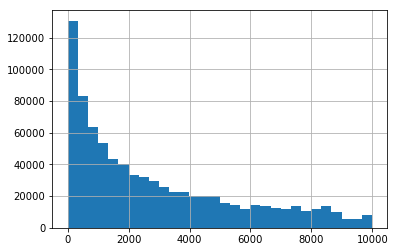

In [120]:
masterdf[masterdf['product_total_purchase_count'] < 10000]['product_total_purchase_count'].hist(bins = 30);

In [123]:
masterdf['product_total_purchase_count'].max()

472565.0

In [122]:
masterdf['product_total_purchase_count'].fillna(-1, inplace=True)

In [124]:
product_total_purchase_bins = [-3, 0, 2000, 5000, 10000, 100000, 500000]
product_total_purchase_group_names = ['NaN', ' 1-2,000', '2,001-5,000', '5,001-10,000', '10,001-100,000', '>100,000']
masterdf['product_total_purchase_category'] = pd.cut(masterdf['product_total_purchase_count'], product_total_purchase_bins, labels=product_total_purchase_group_names)

In [128]:
masterdf['product_user_count'].fillna(-2, inplace = True)

In [131]:
masterdf['product_user_count'].max()

73956.0

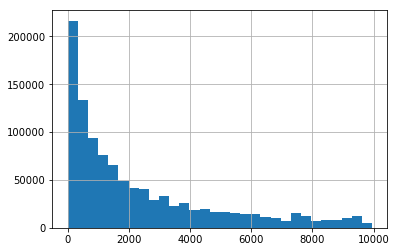

In [130]:
masterdf[masterdf['product_user_count'] < 10000]['product_user_count'].hist(bins = 30)

In [132]:
product_user_count_bins = [-3, 0, 2000, 5000, 10000, 50000, 100000]
product_user_count_group_names = ['NaN', ' 1-2,000', '2,001-5,000', '5,001-10,000', '10,001-50,000', '>50,000']
masterdf['product_user_count_category'] = pd.cut(masterdf['product_user_count'], product_user_count_bins, labels=product_user_count_group_names)

In [138]:
masterdf.days_since_prior_order.unique()

array([  9.,  30.,  24.,  14.,  26.,  17.,  13.,   8.,  27.,   6.,  12.,
        11.,   4.,   7.,  10.,  16.,   0.,   3.,  19.,  21.,   5.,  23.,
        15.,   2.,  18.,  29.,   1.,  20.,  22.,  28.,  25.])

In [141]:
days_since_prior_order_bins = [-1, 3, 10, 20, 30]
days_since_prior_order_group_names = [' 0-3', '4-10', '11-20', '21-30']
masterdf['days_since_prior_order_category'] = pd.cut(masterdf['days_since_prior_order'], days_since_prior_order_bins, labels=days_since_prior_order_group_names)

In [142]:
#pickle.dump(masterdf, open('data/masterdf_all.p', 'wb'))

In [89]:
#masterdf = pickle.load(open('data/masterdf_all.p', 'rb'))

In [173]:
masterdf.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'days_since_first_order', 'user_count_of_order',
       'user_average_order_interval', 'user_product_count',
       'user_product_average_interval', 'product_total_purchase_count',
       'product_user_count', 'product_reorder_user_count',
       'product_reorder_ratio', 'add_to_cart_order_categories', 'order_day',
       'time_of_day', 'order_time', 'user_history_category',
       'user_count_of_order_category', 'user_order_interval_category',
       'user_product_count_category', 'user_product_average_interval_category',
       'product_total_purchase_category', 'product_user_count_category',
       'days_since_prior_order_category'],
      dtype='object')

In [174]:
masterdf.drop(['order_id', 'product_id', 'add_to_cart_order', 'user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'days_since_first_order', 'user_count_of_order', 'user_average_order_interval', 'user_product_count', 'user_product_average_interval', 'product_total_purchase_count', 'order_day', 'time_of_day', 'product_user_count', 'product_reorder_user_count'], axis = 1, inplace=True)

In [175]:
masterdf.columns

Index(['reordered', 'product_reorder_ratio', 'add_to_cart_order_categories',
       'order_time', 'user_history_category', 'user_count_of_order_category',
       'user_order_interval_category', 'user_product_count_category',
       'user_product_average_interval_category',
       'product_total_purchase_category', 'product_user_count_category',
       'days_since_prior_order_category'],
      dtype='object')

In [176]:
dummy_columns = ['add_to_cart_order_categories', 'order_time', 'user_history_category', 'user_count_of_order_category', 'user_order_interval_category', 'user_product_count_category',
'user_product_average_interval_category', 'product_total_purchase_category', 'product_user_count_category', 'days_since_prior_order_category']

In [177]:
for column in dummy_columns:
    masterdf = pd.concat([masterdf, pd.get_dummies(masterdf[column], prefix=column)], axis = 1)

In [93]:
masterdf.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'days_since_first_order', 'user_count_of_order',
       'user_average_order_interval', 'user_product_count',
       'user_product_average_interval', 'product_total_purchase_count',
       'product_user_count', 'product_reorder_user_count',
       'product_reorder_ratio', 'add_to_cart_order_categories', 'order_day',
       'time_of_day', 'order_time', 'user_history_category',
       'user_count_of_order_category', 'user_order_interval_category',
       'user_product_count_category', 'user_product_average_interval_category',
       'product_total_purchase_category', 'product_user_count_category',
       'days_since_prior_order_category'],
      dtype='object')

In [105]:
masterdf.drop(masterdf.columns[4:11], axis = 1)

,order_id,product_id,add_to_cart_order,reordered,user_product_count,user_product_average_interval,product_total_purchase_count,product_user_count,product_reorder_user_count,product_reorder_ratio,add_to_cart_order_categories,order_day,time_of_day,order_time,user_history_category,user_count_of_order_category,user_order_interval_category,user_product_count_category,user_product_average_interval_category,product_total_purchase_category,product_user_count_category,days_since_prior_order_category
0,1,49302,1,1,2.0,7.000000,163.0,62.0,27.0,0.435484,1-2,weekday,morning,weekday morning,2mon,4-10,6-10,1-10,1-10,"1-2,000","1-2,000",4-10
1,1,11109,2,1,2.0,7.000000,4472.0,1280.0,704.0,0.550000,1-2,weekday,morning,weekday morning,2mon,4-10,6-10,1-10,1-10,"2,001-5,000","1-2,000",4-10
2,1,10246,3,0,-2.0,-2.000000,23826.0,11328.0,4771.0,0.421169,3-5,weekday,morning,weekday morning,2mon,4-10,6-10,NaN,NaN,"10,001-100,000","10,001-50,000",4-10
3,1,49683,4,0,-2.0,-2.000000,97315.0,30002.0,17002.0,0.566696,3-5,weekday,morning,weekday morning,2mon,4-10,6-10,NaN,NaN,"10,001-100,000","10,001-50,000",4-10
4,1,43633,5,1,2.0,22.000000,653.0,341.0,114.0,0.334311,3-5,weekday,morning,weekday morning,2mon,4-10,6-10,1-10,11-30,"1-2,000","1-2,000",4-10
5,1,13176,6,0,-2.0,-2.000000,379450.0,63537.0,45231.0,0.711884,6-10,weekday,morning,weekday morning,2mon,4-10,6-10,NaN,NaN,">100,000",">50,000",4-10
6,1,47209,7,0,-2.0,-2.000000,213584.0,43453.0,29031.0,0.668101,6-10,weekday,morning,weekday morning,2mon,4-10,6-10,NaN,NaN,">100,000","10,001-50,000",4-10
7,1,22035,8,1,2.0,7.000000,59676.0,14037.0,8681.0,0.618437,6-10,weekday,morning,weekday morning,2mon,4-10,6-10,1-10,1-10,"10,001-100,000","10,001-50,000",4-10
8,36,39612,1,0,-2.0,-2.000000,728.0,478.0,109.0,0.228033,1-2,weekday,afternoon,weekday afternoon,1year,11-30,11-20,NaN,NaN,"1-2,000","1-2,000",21-30
9,36,19660,2,1,15.0,19.857143,56087.0,10529.0,6561.0,0.623136,1-2,weekday,afternoon,weekday afternoon,1year,11-30,11-20,11-30,11-30,"10,001-100,000","10,001-50,000",21-30


In [180]:
masterdf.drop(['add_to_cart_order_categories',
       'order_time', 'user_history_category', 'user_count_of_order_category',
       'user_order_interval_category', 'user_product_count_category',
       'user_product_average_interval_category',
       'product_total_purchase_category', 'product_user_count_category',
       'days_since_prior_order_category'], axis = 1, inplace = True)

In [181]:
masterdf.head()

,reordered,product_reorder_ratio,add_to_cart_order_categories_1-2,add_to_cart_order_categories_3-5,add_to_cart_order_categories_6-10,add_to_cart_order_categories_>10,order_time_weekday afternoon,order_time_weekday early_morning,order_time_weekday morning,order_time_weekday night,...,"product_user_count_category_ 1-2,000","product_user_count_category_10,001-50,000","product_user_count_category_2,001-5,000","product_user_count_category_5,001-10,000","product_user_count_category_>50,000",product_user_count_category_NaN,days_since_prior_order_category_ 0-3,days_since_prior_order_category_11-20,days_since_prior_order_category_21-30,days_since_prior_order_category_4-10
0,1,0.435484,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,1,0.550000,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0.421169,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0.566696,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0.334311,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [182]:
#pickle.dump(masterdf, open('data/masterdf_clean.p', 'wb'))

## Models!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [4]:
import pickle
masterdf = pickle.load(open('data/masterdf_clean.p', 'rb'))

In [5]:
masterdf['product_reorder_ratio'].fillna(0, inplace = True)

In [17]:
newdf = masterdf.sample(frac = 1)

In [19]:
X = newdf.drop('reordered', axis = 1)
y = newdf.reordered

In [20]:
cross_validator = KFold(n_splits = 5, shuffle=True, random_state=731)

In [21]:
#ALL model
%timeit
scores = ['accuracy', 'precision', 'recall', 'f1']
models = ['Logistic_Regression', 'Naive_Bayes', 'SVM', 'Decision_Tree', 'Random_Forest']
model_functions = {'Logistic_Regression': LogisticRegression(), 'Naive_Bayes': GaussianNB(), 'SVM': SVC(), 'Decision_Tree': DecisionTreeClassifier(), 'Random_Forest': RandomForestClassifier()}

score_table = pd.DataFrame(columns = scores, index = models)

In [47]:
newdf.shape

(1384617, 56)

In [46]:
newdf.reordered.value_counts()

1    828824
0    555793
Name: reordered, dtype: int64

In [60]:
%timeit
for model in models:
    print(model)
    for score in scores:
        print(score)
        score_table.set_value(model, score, np.mean(cross_val_score(model_functions[model], X.iloc[0:1000, 35:], y[0:1000], cv=cross_validator, scoring=score)))

Logistic_Regression
accuracy
precision
recall
f1
Naive_Bayes
accuracy
precision
recall
f1
SVM
accuracy
precision
recall
f1
Decision_Tree
accuracy
precision
recall
f1
Random_Forest
accuracy
precision
recall
f1


In [63]:
masterdf.corr()

,reordered,product_reorder_ratio,add_to_cart_order_categories_1-2,add_to_cart_order_categories_3-5,add_to_cart_order_categories_6-10,add_to_cart_order_categories_>10,order_time_weekday afternoon,order_time_weekday early_morning,order_time_weekday morning,order_time_weekday night,...,"product_user_count_category_ 1-2,000","product_user_count_category_10,001-50,000","product_user_count_category_2,001-5,000","product_user_count_category_5,001-10,000","product_user_count_category_>50,000",product_user_count_category_NaN,days_since_prior_order_category_ 0-3,days_since_prior_order_category_11-20,days_since_prior_order_category_21-30,days_since_prior_order_category_4-10
reordered,1.000000,0.300122,0.109180,0.054906,-0.019903,-0.123056,-0.015571,0.001075,0.006128,-0.004096,...,-0.124294,0.095271,-0.002207,0.013247,0.103636,-0.003113,0.038312,0.034839,-0.149907,0.107497
product_reorder_ratio,0.300122,1.000000,0.116168,0.048206,-0.023691,-0.119119,-0.017094,-0.004550,-0.003005,-0.007690,...,-0.454752,0.346502,-0.019408,0.046374,0.409189,-0.008530,-0.008764,0.005208,-0.032493,0.035034
add_to_cart_order_categories_1-2,0.109180,0.116168,1.000000,-0.264396,-0.290285,-0.317556,0.012701,0.000729,0.009621,0.001475,...,-0.013966,-0.016651,-0.001949,-0.003407,0.079446,0.000247,0.037779,-0.013311,0.005654,-0.015433
add_to_cart_order_categories_3-5,0.054906,0.048206,-0.264396,1.000000,-0.339059,-0.370911,0.012545,-0.000479,0.002905,0.001186,...,-0.012269,0.010082,-0.003801,-0.001219,0.020121,-0.001417,0.030368,-0.010216,-0.001932,-0.005911
add_to_cart_order_categories_6-10,-0.019903,-0.023691,-0.290285,-0.339059,1.000000,-0.407231,0.002196,-0.000415,-0.005124,-0.001769,...,-0.005882,0.017039,0.000131,0.001894,-0.023467,0.000356,-0.002268,-0.000765,-0.003649,0.005869
add_to_cart_order_categories_>10,-0.123056,-0.119119,-0.317556,-0.370911,-0.407231,1.000000,-0.024322,0.000228,-0.005821,-0.000627,...,0.028680,-0.011688,0.005007,0.002160,-0.062656,0.000752,-0.057482,0.021314,0.000540,0.012751
order_time_weekday afternoon,-0.015571,-0.017094,0.012701,0.012545,0.002196,-0.024322,1.000000,-0.087231,-0.344845,-0.188573,...,0.018488,-0.013087,-0.002408,-0.005499,-0.006374,0.000304,0.020505,0.002474,0.007364,-0.021667
order_time_weekday early_morning,0.001075,-0.004550,0.000729,-0.000479,-0.000415,0.000228,-0.087231,1.000000,-0.077425,-0.042339,...,0.008941,-0.006179,-0.001522,-0.003793,-0.000789,-0.000357,0.000043,0.002909,-0.005749,0.003517
order_time_weekday morning,0.006128,-0.003005,0.009621,0.002905,-0.005124,-0.005821,-0.344845,-0.077425,1.000000,-0.167376,...,0.010121,-0.012893,0.003476,-0.001869,-0.003051,0.000596,0.003589,0.000423,-0.010995,0.009357
order_time_weekday night,-0.004096,-0.007690,0.001475,0.001186,-0.001769,-0.000627,-0.188573,-0.042339,-0.167376,1.000000,...,0.005025,-0.004132,0.000417,-0.002521,-0.000950,0.000251,0.019841,-0.000769,-0.016837,0.007503


In [61]:
score_table

,accuracy,precision,recall,f1
Logistic_Regression,0.809,0.992697,0.691821,0.814822
Naive_Bayes,0.804,0.995652,0.681957,0.808934
SVM,0.806,1,0.681957,0.810435
Decision_Tree,0.797,0.957043,0.699737,0.807279
Random_Forest,0.803,0.938639,0.712944,0.809456


In [37]:
score_table

,accuracy,precision,recall,f1
Logistic_Regression,0.607,0.614983,0.951952,0.746763
Naive_Bayes,0.605,0.625878,0.890494,0.732073
SVM,0.607,0.614983,0.951952,0.746763
Decision_Tree,0.61,0.617977,0.943619,0.7466
Random_Forest,0.607,0.617977,0.939452,0.7466


In [79]:
X.shape

(1384617, 55)

In [65]:
newdf = pickle.load(open("data/user_order_product_new.p", "rb"))

In [68]:
newdf

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,days_since_prior_purchase_product
24076664,2539329,196,1,0,1,prior,1,2,8,NaN,0.0,NaN
22742744,2398795,196,1,1,1,prior,2,3,7,15.0,15.0,15.0
4488095,473747,196,1,1,1,prior,3,3,12,21.0,36.0,21.0
21376074,2254736,196,1,1,1,prior,4,4,7,29.0,65.0,29.0
4089398,431534,196,1,1,1,prior,5,4,15,28.0,93.0,28.0
31927070,3367565,196,1,1,1,prior,6,2,7,19.0,112.0,19.0
5212927,550135,196,1,1,1,prior,7,1,9,20.0,132.0,20.0
29474806,3108588,196,2,1,1,prior,8,1,14,14.0,146.0,14.0
21760446,2295261,196,4,1,1,prior,9,1,16,0.0,146.0,0.0
24181266,2550362,196,1,1,1,prior,10,4,8,30.0,176.0,30.0
